In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers
from tensorflow.keras.datasets import mnist
import numpy as np

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers
from tensorflow.keras.datasets import mnist
import numpy as np

In [3]:
def mutual_information_regularizer(logits, temperature=0.1):
    """
    Tính thông tin tương hỗ giữa đầu vào và đầu ra của mô hình.
    
    Args:
        logits (tensor): Đầu ra từ mô hình (trước khi áp dụng softmax).
        temperature (float): Nhiệt độ để điều chỉnh độ mượt của phân phối xác suất.
        
    Returns:
        loss (tensor): Giá trị của bộ điều chỉnh thông tin tương hỗ.
    """
    # Chuẩn hóa đầu ra (logits) thành phân phối xác suất
    probs = tf.nn.softmax(logits / temperature)
    
    # Tính entropy của đầu ra (H(Ŷ))
    marginal_entropy = -tf.reduce_mean(tf.reduce_sum(probs * tf.math.log(probs + 1e-9), axis=-1))
    
    # Tính entropy có điều kiện (H(Ŷ|X))
    conditional_entropy = -tf.reduce_mean(tf.reduce_sum(probs * tf.math.log(probs + 1e-9), axis=-1))
    
    # Thông tin tương hỗ: I(X; Ŷ) = H(Ŷ) - H(Ŷ|X)
    mutual_info = marginal_entropy - conditional_entropy
    
    return mutual_info

In [4]:
def custom_loss(y_true, y_pred, model, inputs, lambda_mid=0.1):
    """
    Hàm mất mát tùy chỉnh với MID.
    
    Args:
        y_true (tensor): Nhãn thực tế.
        y_pred (tensor): Dự đoán của mô hình.
        model (keras.Model): Mô hình học máy.
        inputs (tensor): Dữ liệu đầu vào.
        lambda_mid (float): Hệ số điều chỉnh cho MID.
        
    Returns:
        loss (tensor): Tổng hàm mất mát bao gồm MID.
    """
    # Mất mát chính: sparse categorical crossentropy
    loss = losses.sparse_categorical_crossentropy(y_true, y_pred)
    
    # Tính thông tin tương hỗ MID
    mi_loss = mutual_information_regularizer(model(inputs))  # Truyền đầu vào vào mô hình để lấy logits
    
    # Tổng hàm mất mát
    total_loss = loss + lambda_mid * mi_loss
    return total_loss


In [5]:
# Build the model
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten

def create_simple_nn():
  model = Sequential([
      Flatten(input_shape=(28, 28, 1)),
      Dense(128, activation='relu'),
      Dense(10, activation='softmax')
  ])

  return model

In [6]:
def create_cnn():
  model = Sequential([
      layers.Conv2D(32, kernel_size=3, activation='relu', input_shape=(28, 28, 1)),
      layers.MaxPooling2D(pool_size=2),
      layers.Conv2D(64, kernel_size=3, activation='relu'),
      layers.MaxPooling2D(pool_size=2),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(10, activation='softmax')
  ])
  return model

In [7]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize to [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0

# Add channel dimension
x_train = x_train[..., np.newaxis]
x_test = x_test[..., np.newaxis]

In [9]:
victim_epochs = 10
victim_batch_size = 128

## Simple_CNN

In [10]:
# Create Simple CNN model
simple_nn_model = create_simple_nn()
simple_nn_model.compile(optimizer='adam', 
                        loss=lambda y_true, y_pred: custom_loss(y_true, y_pred, simple_nn_model, x_train), 
                        metrics=['accuracy'])


c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
history_simple_nn_model = simple_nn_model.fit(
    x_train,
    y_train,
    epochs=victim_epochs,
    batch_size=victim_batch_size,
    validation_split=0.2)

Epoch 1/10


KeyboardInterrupt: 

In [11]:
simple_nn_model.save("./MID/victim_simple_cnn_model.keras")

c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:                         loss=lambda y_true, y_pred: custom_loss(y_true, y_pred, simple_nn_model, x_train), 

  return {key: serialize_keras_object(value) for key, value in obj.items()}


In [12]:
loss, acc = simple_nn_model.evaluate(x_test, y_test)
print(f"Victim Model Accuracy On Test Set: {acc * 100.0:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - accuracy: 0.9732 - loss: 0.0863
Victim Model Accuracy On Test Set: 97.60%


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict class probabilities
y_pred_prob = simple_nn_model.predict(x_test)

# Convert predictions to class indices
y_pred = np.argmax(y_pred_prob, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

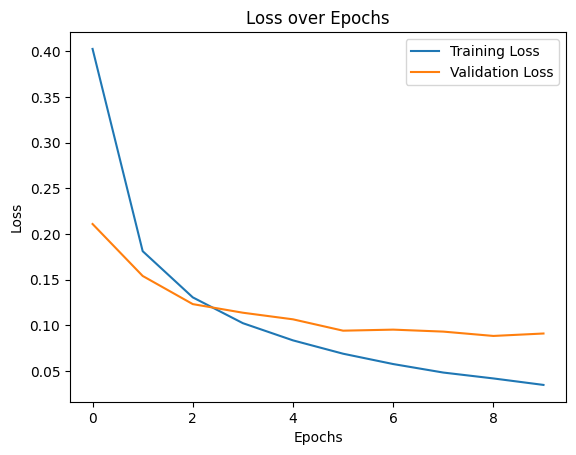

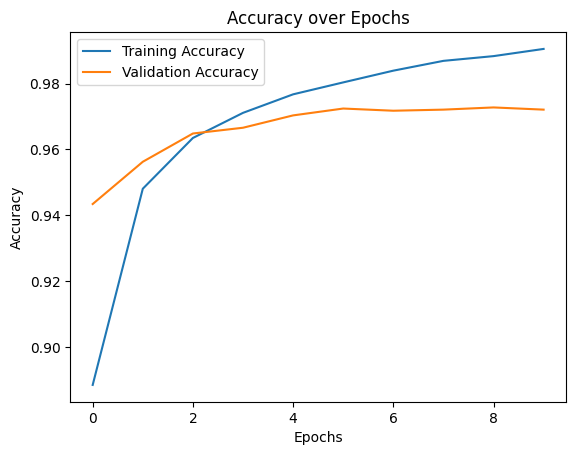

In [13]:
import matplotlib.pyplot as plt

# Plot loss
plt.plot(history_simple_nn_model.history['loss'], label='Training Loss')
plt.plot(history_simple_nn_model.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_simple_nn_model.history['accuracy'], label='Training Accuracy')
plt.plot(history_simple_nn_model.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Convolutional CNN

In [ ]:
# Define victim model
c_nn_model = create_cnn()
c_nn_model.compile(optimizer='adam', 
                        loss=lambda y_true, y_pred: custom_loss(y_true, y_pred, simple_nn_model, x_train), 
                        metrics=['accuracy'])


c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


: 

In [ ]:
# Train victim model
history_c_nn_model = c_nn_model.fit(
    x_train,
    y_train,
    epochs=victim_epochs,
    batch_size=victim_batch_size,
    validation_split=0.2)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.8388 - loss: 0.5635

In [ ]:
c_nn_model.save("./MID/victim_cnn_model.keras")

In [ ]:
# Evaluate victim model
loss, acc = c_nn_model.evaluate(x_test, y_test)
print(f"Victim Model Accuracy On Test Set: {acc * 100.0:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 78ms/step - accuracy: 0.9860 - loss: 0.0493
Victim Model Accuracy On Test Set: 99.00%


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict class probabilities
y_pred_prob = c_nn_model.predict(x_test)

# Convert predictions to class indices
y_pred = np.argmax(y_pred_prob, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

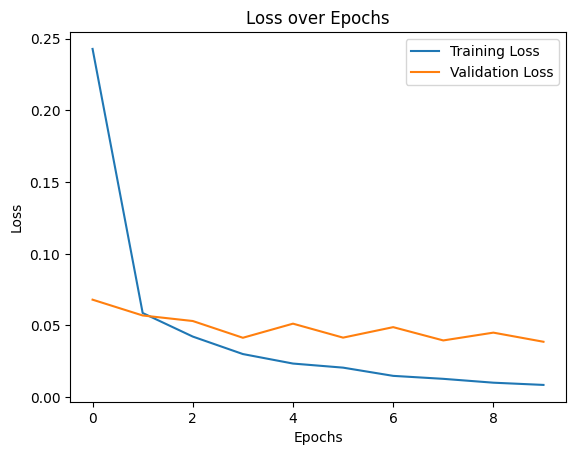

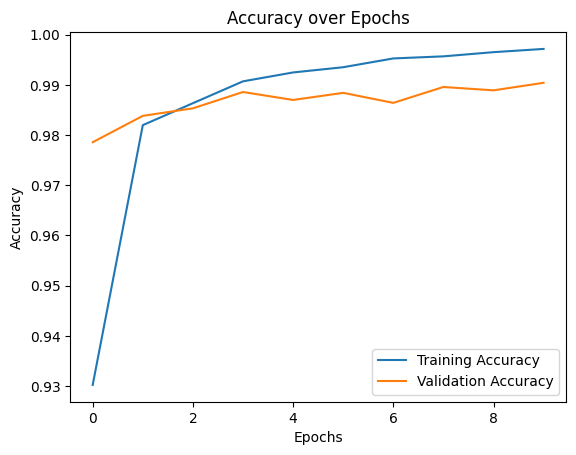

In [ ]:
# Accessing and Displaying Training History
import matplotlib.pyplot as plt

# Plot loss
plt.plot(history_c_nn_model.history['loss'], label='Training Loss')
plt.plot(history_c_nn_model.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_c_nn_model.history['accuracy'], label='Training Accuracy')
plt.plot(history_c_nn_model.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()